In [300]:
import pandas as pd
import ast
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

In [301]:
games = pq.read_table("datasets/Parquet/games.parquet").to_pandas()
games = games[['id', 'app_name', 'price','release_year', 'genres']]

In [302]:
games.head()

,id,app_name,price,release_year,genres
0,761140,Lost Summoner Kitty,4.99,2018,"[Strategy, Action, Indie, Casual, Simulation]"
1,643980,Ironbound,0.00,2018,"[Free to Play, Strategy, Indie, RPG]"
2,670290,Real Pool 3D - Poolians,0.00,2017,"[Free to Play, Simulation, Sports, Casual, Indie]"
3,767400,弹炸人2222,0.99,2017,"[Action, Adventure, Casual]"
4,772540,Battle Royale Trainer,3.99,2018,"[Action, Adventure, Simulation]"


## Preparación de los datos

### Revisamos la columna 'price'

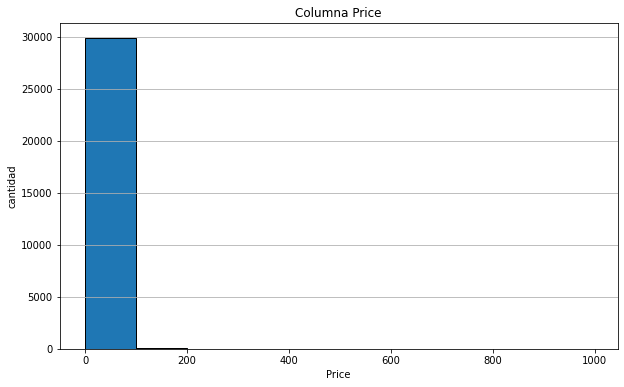

In [303]:
plt.figure(figsize=(10, 6))
plt.hist(games['price'], bins=10, edgecolor='black')
plt.title('Columna Price')
plt.xlabel('Price')
plt.ylabel('cantidad')
plt.grid(axis='y')
plt.show()

Notamos que la columna 'price' podría generar sesgo al tener solo valores positivos.

Primero usamos una transformación logaritmica, para que sume 1 a cada valor antes de aplicar el logaritmo y evitar errores si el valor es 0.

Usamos games['price'] = np.log1p(games['price']), pero los resultados arrojados no aparentan ser los mas útiles

In [304]:
# Aplicar transformación logarítmica a la columna 'price'
# games['price'] = np.log1p(games['price'])

Así que optamos por usar una expresión lambda a la hora de hacer la transformación logarítmica a la columna 'price'

In [305]:
# Aplicar transformación logarítmica a la columna 'price'
games['price'] = games['price'].apply(lambda x: np.log(x + 1) if (pd.notna(x) and x > 0) else x)

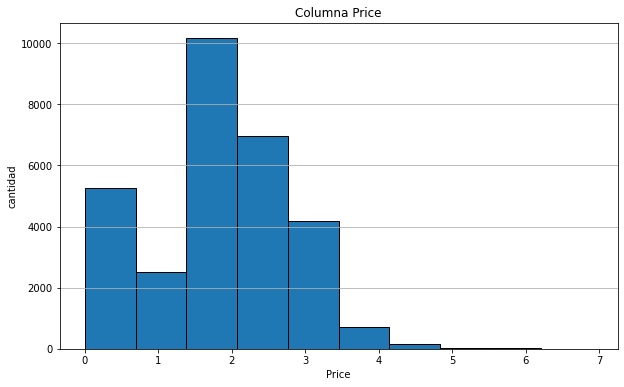

In [306]:
plt.figure(figsize=(10, 6))
plt.hist(games['price'], bins=10, edgecolor='black')
plt.title('Columna Price')
plt.xlabel('Price')
plt.ylabel('cantidad')
plt.grid(axis='y')
plt.show()

Se redujo considerablemente el rango despues de usar la transformación logaritmica

Ahora rellenaremos los valores faltantes con el valor promedio

In [307]:
promedio = games['price'].mean()
games['price'] = games['price'].fillna(promedio)

### Filtro de outliers

In [308]:
# Calcula el rango intercuartil (IQR) de la columna 'price'
Q1 = games['price'].quantile(0.25)
Q3 = games['price'].quantile(0.75)
price_iqr = Q3 - Q1

# Calcula los límites inferior y superior para identificar outliers
lower_bound = Q1 - 1.5 * price_iqr
upper_bound = Q3 + 1.5 * price_iqr

# Filtra los outliers
filtered_games = games[(games['price'] >= lower_bound) & (games['price'] <= upper_bound)]

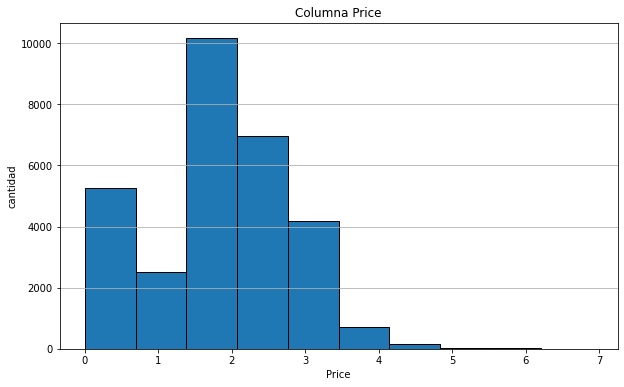

In [309]:
plt.figure(figsize=(10, 6))
plt.hist(games['price'], bins=10, edgecolor='black')
plt.title('Columna Price')
plt.xlabel('Price')
plt.ylabel('cantidad')
plt.grid(axis='y')
plt.show()

La grafica quedó mas estable, teniendo en cuenta que se borraron los outliers

### Columna 'release_year'

In [310]:
# Inicializa el MinMaxScaler
scaler = MinMaxScaler()

# Aplica la transformación a la columna release_year
games['release_year'] = scaler.fit_transform(games[['release_year']])

# Rellena los valores faltantes en la columna release_year con el promedio
mean_release_year = games['release_year'].mean()
games['release_year'] = games['release_year'].fillna(mean_release_year)

# Muestra las primeras filas del DataFrame
print(games.head())

       id                 app_name     price  release_year  \
0  761140      Lost Summoner Kitty  1.790091      0.941176   
1  643980                Ironbound  0.000000      0.941176   
2  670290  Real Pool 3D - Poolians  0.000000      0.921569   
3  767400                  弹炸人2222  0.688135      0.921569   
4  772540    Battle Royale Trainer  1.607436      0.941176   

                                              genres  
0      [Strategy, Action, Indie, Casual, Simulation]  
1               [Free to Play, Strategy, Indie, RPG]  
2  [Free to Play, Simulation, Sports, Casual, Indie]  
3                        [Action, Adventure, Casual]  
4                    [Action, Adventure, Simulation]  


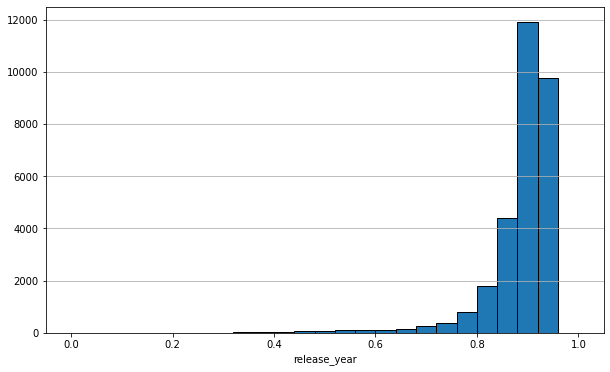

In [311]:
plt.figure(figsize=(10, 6))
plt.hist(games['release_year'], bins=25, edgecolor='black')
plt.xlabel('release_year')
plt.ylabel('')
plt.grid(axis='y')
plt.show()

### Filtro de outliers

In [312]:
# Calcular los cuartiles Q1 y Q3
q1_release_year = games['release_year'].quantile(0.25)
q3_release_year = games['release_year'].quantile(0.75)

# Calcular el rango intercuartílico (IQR) para release_year
iqr_release_year = q3_release_year - q1_release_year

# Calcular los límites inferior y superior para identificar valores atípicos
limite_inferior_release_year = q1_release_year - 1.5 * iqr_release_year
limite_superior_release_year = q3_release_year + 1.5 * iqr_release_year

# Filtrar los datos de acuerdo con los límites inferior y superior
games = games[(games['release_year'] >= limite_inferior_release_year) & (games['release_year'] <= limite_superior_release_year)]

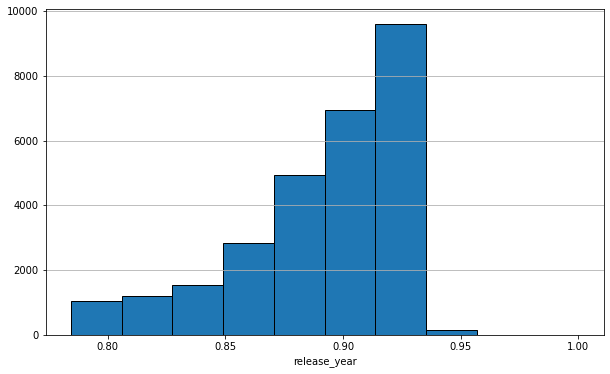

In [313]:
plt.figure(figsize=(10, 6))
plt.hist(games['release_year'], bins=10, edgecolor='black')
plt.xlabel('release_year')
plt.ylabel('')
plt.grid(axis='y')
plt.show()

La grafica quedó mas estable, teniendo en cuenta que se borraron los outliers

### Transformación de la columna 'genres'

Ahora vamos a transformar la columna 'genres' para que queden los generos mas utilizados para facilitar la creacion de dummies.

In [314]:
#Separamos los géneros por filas
generos_games = games.explode('genres')

#Obtención del porcentage
generos_games['genres'].value_counts()/generos_games.shape[0]*100

genres
Indie                     21.886509
Action                    15.412631
Adventure                 11.821034
Casual                    11.662802
Strategy                   9.416178
Simulation                 9.159733
RPG                        7.566498
Free to Play               2.966853
Early Access               1.969718
Sports                     1.752830
Massively Multiplayer      1.655981
Racing                     1.428182
Pending Classification     1.242668
Utilities                  0.710681
Education                  0.409221
Web Publishing             0.372391
Video Production           0.166417
Software Training          0.156868
Audio Production           0.136407
Photo Editing              0.103669
Accounting                 0.002728
Name: count, dtype: float64

Las primeras 7 columnas representan una gran mayoría de los datos (85%)
 así que vamos a utilizar esas columnas y agrupar el resto por una nueva llamada 'other

Ahora transformamos la columna 'genres' usando one-hot encoding

In [315]:
# Eliminar filas con valores nulos en la columna 'genres'
ames = games.dropna(subset=['genres'])

# Crear un objeto MultiLabelBinarizer para la codificación one-hot
mlb = MultiLabelBinarizer()

# Aplicar la codificación one-hot a la columna "genres"
generos_one_hot = pd.DataFrame(mlb.fit_transform(games['genres']), columns=mlb.classes_, index=games.index)

# Definir las categorías que se deben mantener como columnas one-hot
categorias = ['Indie', 'Action', 'Adventure', 'Casual', 'Simulation', 'Strategy', 'RPG']

# Crear una nueva columna 'otros' que agrupe las categorías no seleccionadas
games['other'] = generos_one_hot.drop(columns=categorias).max(axis=1)

# Concatenamos el dataframe
games = pd.concat([games, generos_one_hot[categorias]], axis=1)

# Eliminar la columna 'genres'
games = games.drop('genres', axis=1)

In [316]:
games

,id,app_name,price,release_year,other,Indie,Action,Adventure,Casual,Simulation,Strategy,RPG
0,761140,Lost Summoner Kitty,1.790091,0.941176,0,1,1,0,1,1,1,0
1,643980,Ironbound,0.000000,0.941176,1,1,0,0,0,0,1,1
2,670290,Real Pool 3D - Poolians,0.000000,0.921569,1,1,0,0,1,1,0,0
3,767400,弹炸人2222,0.688135,0.921569,0,0,1,1,1,0,0,0
4,772540,Battle Royale Trainer,1.607436,0.941176,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29956,745400,Kebab it Up!,1.095273,0.941176,0,1,1,1,1,0,0,0
29957,773640,Colony On Mars,1.095273,0.941176,0,1,0,0,1,1,1,0
29958,733530,LOGistICAL: South Africa,1.790091,0.941176,0,1,0,0,1,0,1,0
29959,610660,Russian Roads,1.095273,0.941176,1,1,0,0,0,1,0,0


In [318]:
# Seleccionar todas las características relevantes para la similitud coseno
caracteristicas = games[['Indie', 'Action', 'Adventure', 'Casual', 'Simulation', 'Strategy', 'RPG', 'price', 'release_year']]

# Calcular la similitud coseno entre los juegos
matriz_similitud = cosine_similarity(caracteristicas, caracteristicas)

# Crear un diccionario para almacenar las recomendaciones
num_recommendaciones = 5
recomendaciones_dict = {}

for idx in range(len(matriz_similitud)):
    # Obtener las similitudes para el juego actual
    similitud = matriz_similitud[idx]

    # Enumerar las similitudes y obtener los índices ordenados
    juegos_similares = sorted(list(enumerate(similitud)), key=lambda x: x[1], reverse=True)

    # Excluir el propio juego de las recomendaciones
    juegos_similares = [juego for juego in juegos_similares if juego[0] != idx]

    # Tomar los primeros 5 juegos como recomendaciones, asegurándose de que el índice exista en el DataFrame
    recomendaciones_dict[games.iloc[idx]['id']] = [games.iloc[juego[0]]['app_name'] for juego in juegos_similares[:num_recommendaciones] if juego[0] in games.index]

# Convertir el diccionario en un DataFrame
recomendaciones_df = pd.DataFrame(recomendaciones_dict.items(), columns=['id', 'recomendaciones'])

# Fusionar el DataFrame de recomendaciones con el DataFrame original para obtener el nombre del juego
df_recomendaciones = pd.merge(recomendaciones_df, games[['id', 'app_name']], on='id')

Con esto creamos un dataframe donde se le asignaron 5 recomendaciones a cada juego

In [326]:
df_recomendaciones.head()

,id,recomendaciones,app_name
0,761140,"[Trivia Vault: Mixed Trivia, Vertical Strike E...",Lost Summoner Kitty
1,643980,"[Fort Triumph, Heroes of Arca, Fantasy Grounds...",Ironbound
2,670290,"[Canvas The Gallery, AIRIS, Anomalies - Sights...",Real Pool 3D - Poolians
3,767400,"[Cyber Utopia - Artworks., Crazy Catman, Luke ...",弹炸人2222
4,772540,"[Rocket Craze 3D, Fapic, Beyond Space Remaster...",Battle Royale Trainer


In [337]:
# Exportamos df_recomendaciones en formato parquet
tabla = pa.Table.from_pandas(df_recomendaciones)
pq.write_table(tabla,"datasets/Parquet/EP_ML_recomendacion.parquet")